In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("housing.csv")

## Ten random rows

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
random_rows = df.sample(n=10)
random_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
13311,-117.61,34.08,12.0,4427.0,NaN,2400.0,843.0,4.7147,158700.0,INLAND
7113,-118.02,33.89,36.0,1375.0,NaN,670.0,221.0,5.0839,198200.0,<1H OCEAN
7668,-118.08,33.92,38.0,1335.0,NaN,1011.0,269.0,3.6908,157500.0,<1H OCEAN
18246,-122.08,37.39,4.0,2292.0,NaN,1050.0,584.0,4.8036,340000.0,NEAR BAY
5723,-118.23,34.18,45.0,2332.0,NaN,943.0,339.0,8.1132,446600.0,<1H OCEAN


### Checking the general info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### We have missing values in total_bedrooms column 

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

207 missing values

### Checking if there is any duplicated values

In [7]:
df.duplicated().sum()

0

### checking if there is ? instead of Nan

In [8]:
for i in df.columns:
    print(i,len(df[df[i] == '?']))

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### check if there are 0s where 0 is meaningless

In [9]:
for i in df.columns:
    print(i,len(df[df[i] == 0]))

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### check the count of each category in ocean_proximity

In [10]:
for col in df.columns:
    if df[col].dtype == "object":
        print(f"{col}: {df[col].value_counts()}")

ocean_proximity: ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


### Sending the lable column to the last column for the sake of convention 

In [11]:
# Get the list of column names excluding "median_house_value"
cols = [col for col in df.columns if col != 'median_house_value']

# Add "median_house_value" to the end of the list
cols.append('median_house_value')

# Reindex the DataFrame with the new order of columns
df = df.reindex(columns=cols)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,342200.0
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,INLAND,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,INLAND,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,INLAND,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,INLAND,84700.0


### A useful distinction: numerical columns and categorical column 

In [12]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in df.columns if df[cname].dtype in ["string",'object'] ]
# Select numerical columns
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

## Data visualization

### plotting some histogram 

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


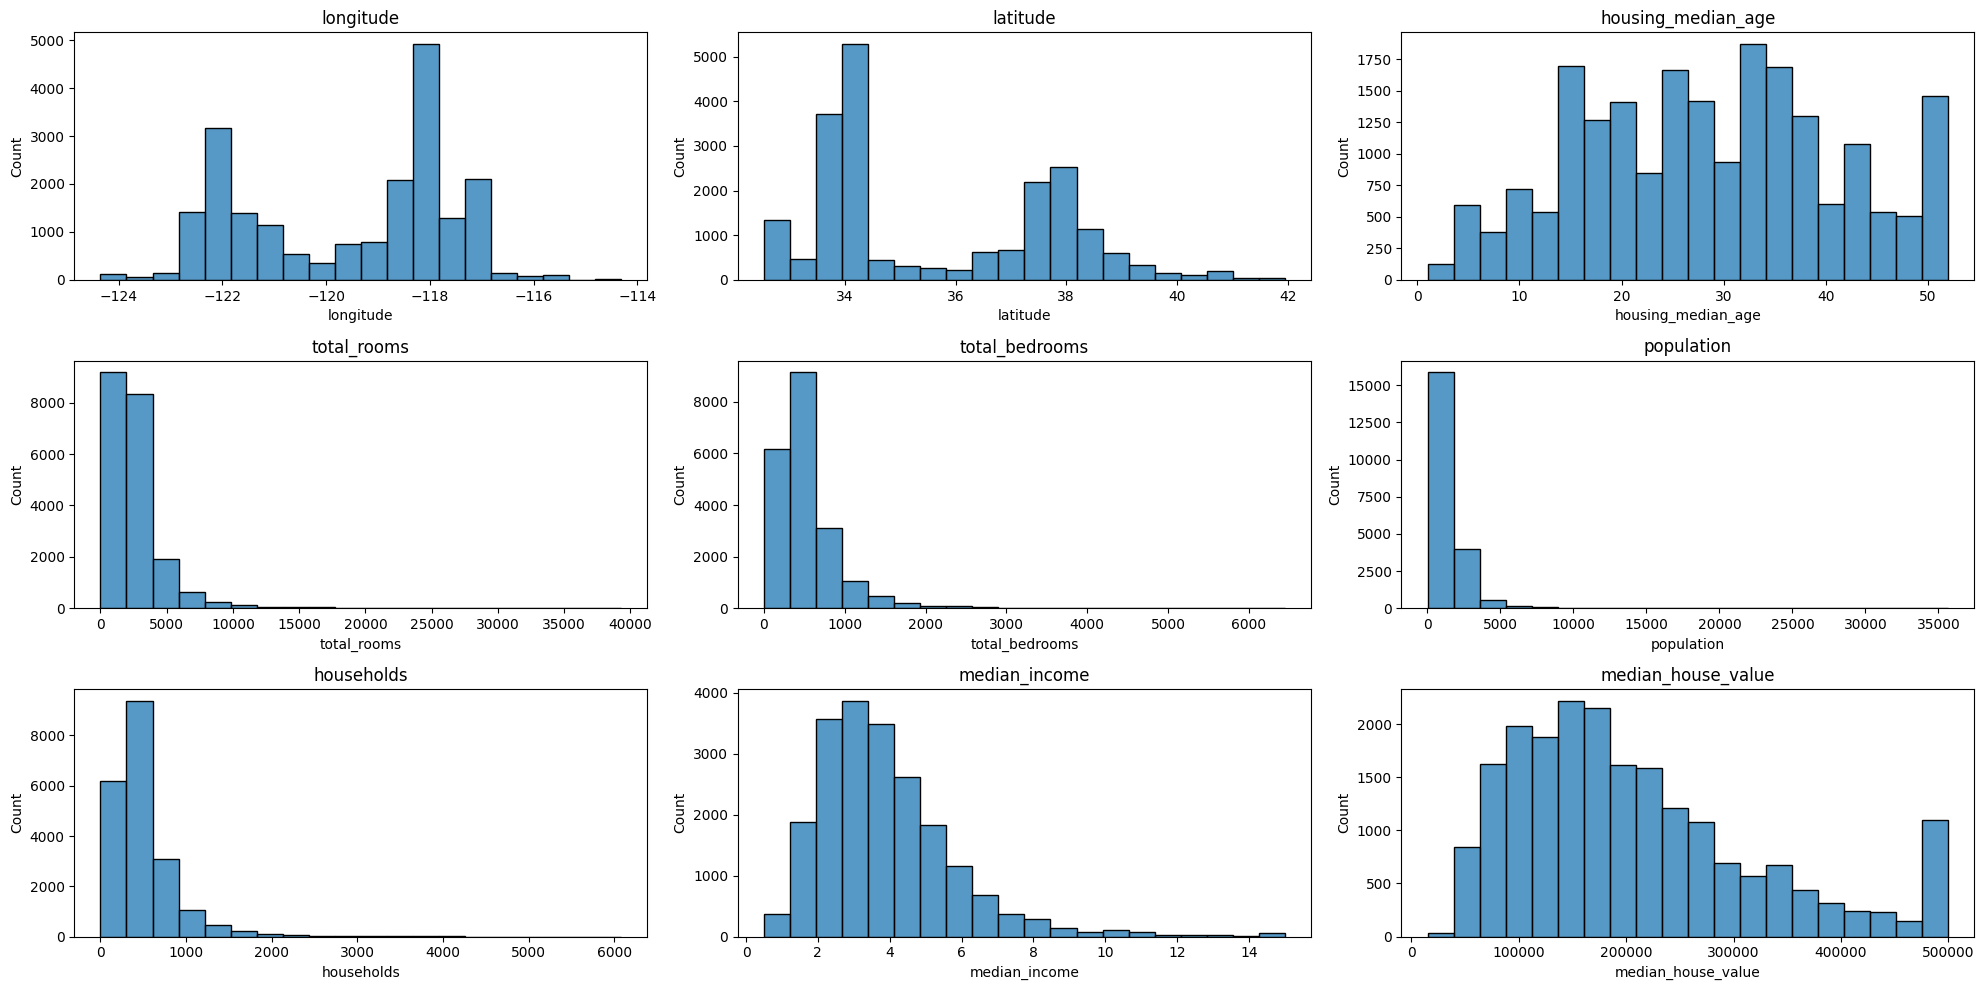

In [13]:
# Calculate the number of rows and columns needed for subplots
num_rows = 3
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(df.loc[:, numerical_cols]):
    sns.histplot(df[col], ax=axes[i], bins=20)
    axes[i].set_title(col)  # Set the title to the column name

# Hide any remaining empty subplots
for i in range(len(df.columns), len(axes)):
    axes[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Pie chart for the only categorical column

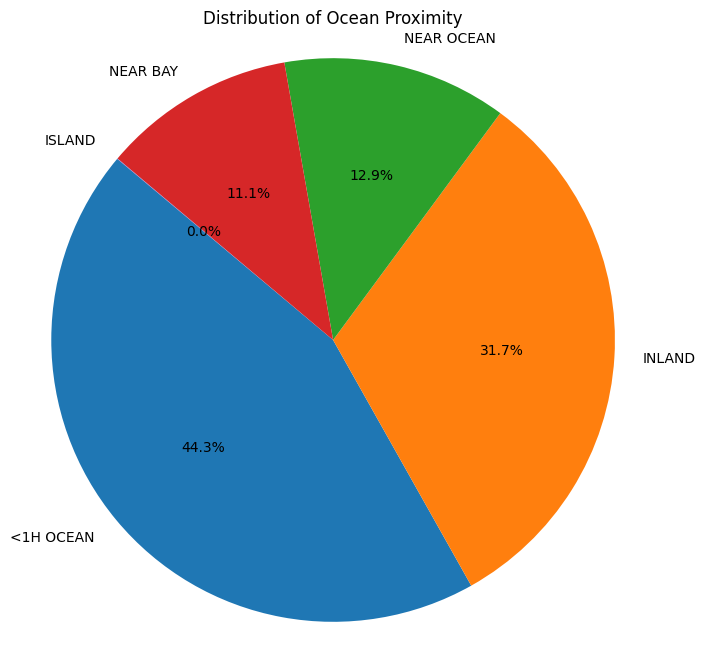

In [14]:
# Get the counts of unique values in the "ocean_proximity" column
ocean_proximity_counts = df['ocean_proximity'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(ocean_proximity_counts, labels=ocean_proximity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ocean Proximity')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Box plot for the numerical columns 

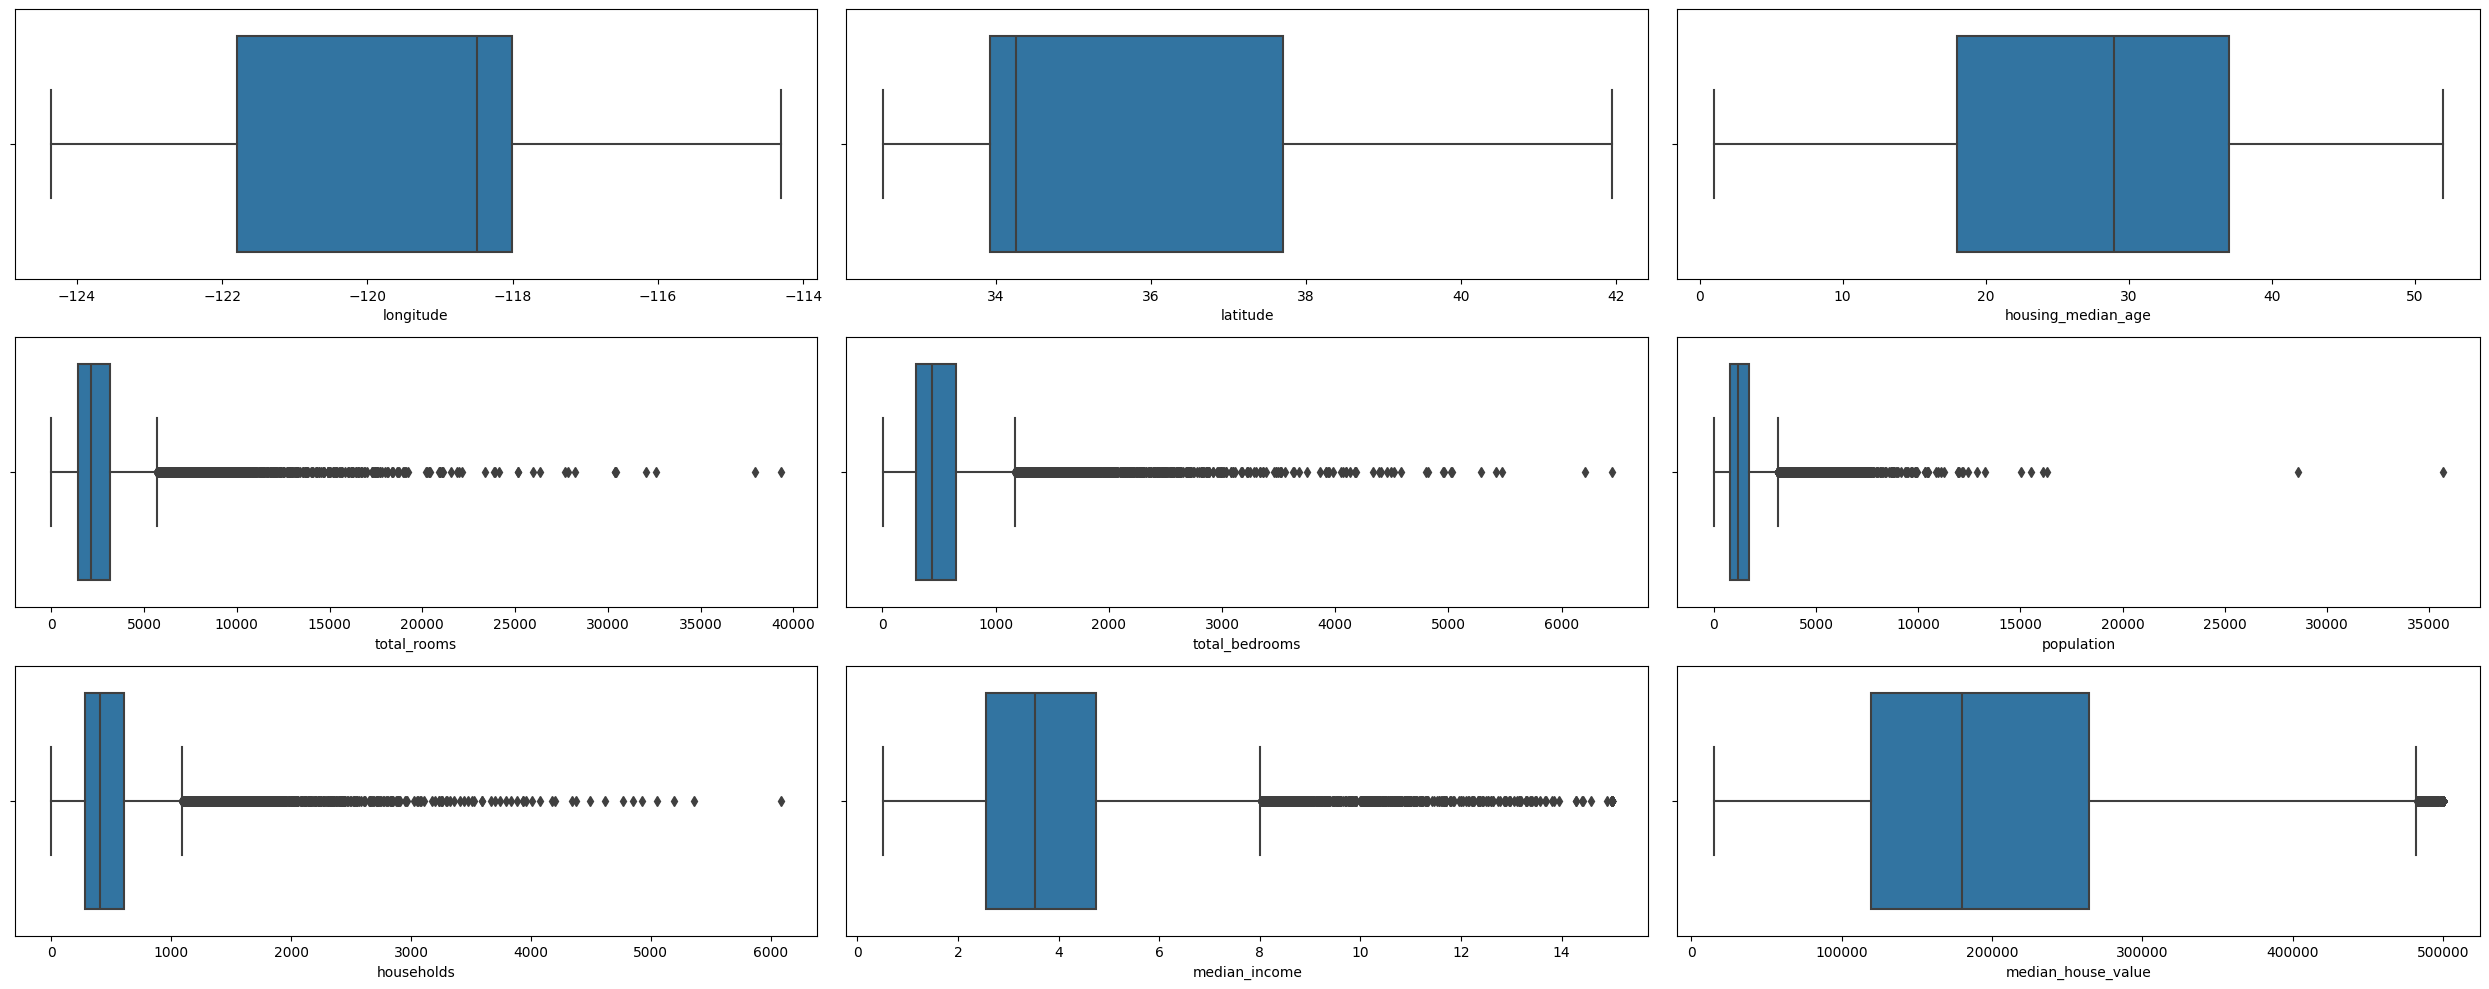

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of rows and columns needed for subplots
num_rows = 3
num_cols = 3  # Number of numerical columns in your DataFrame

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10))

# Plot boxplots for each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i // num_cols, i % num_cols])  # Adjusted indexing

# Set labels for each subplot
for i, col in enumerate(numerical_cols):
    axes[i // num_cols, i % num_cols].set_xlabel(col)  # Adjusted indexing

# Hide any remaining empty subplots
for i in range(len(numerical_cols), num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


### Correlation matrix 

In [16]:
# One-hot encode the 'ocean_proximity' column
one_hot_encoded = pd.get_dummies(df['ocean_proximity'], prefix='ocean_proximity', dtype=int)

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df.drop(["ocean_proximity", "median_house_value"], axis=1), one_hot_encoded , df.loc[: , "median_house_value"]], axis=1)


# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()


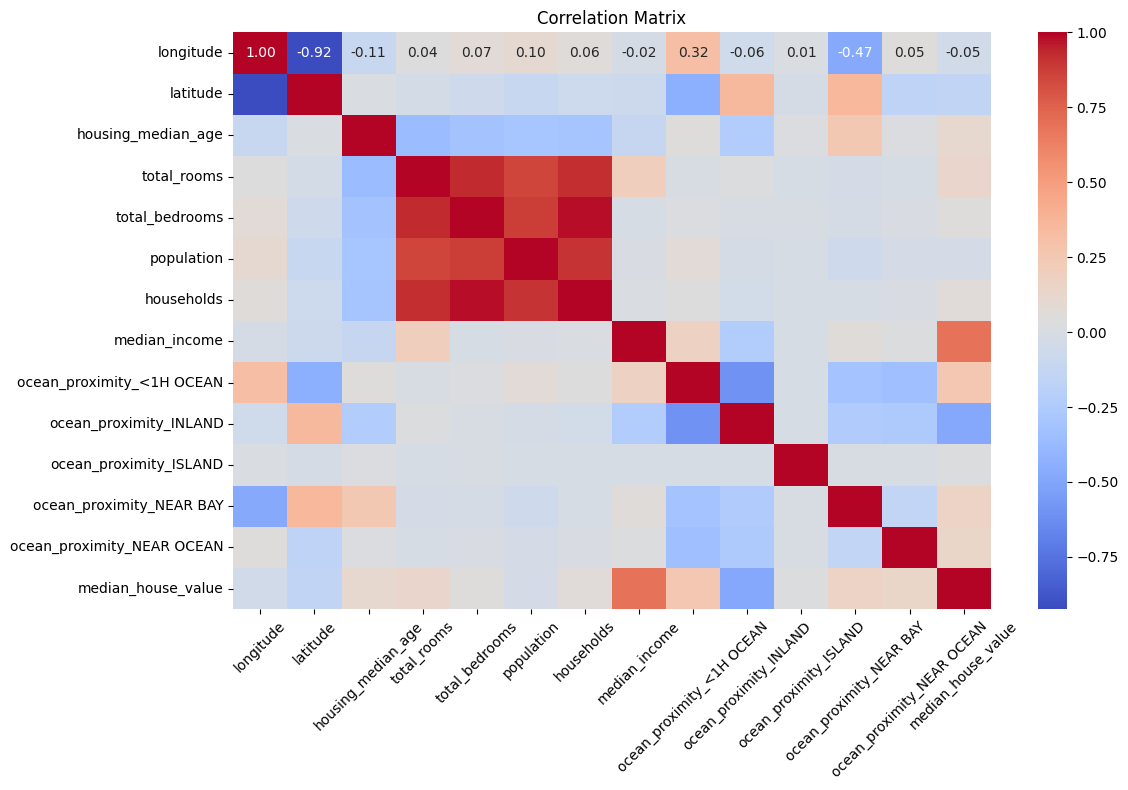

In [17]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.title('Correlation Matrix')
plt.tight_layout()  # Adjust layout parameters to ensure all elements are fully visible
plt.show()



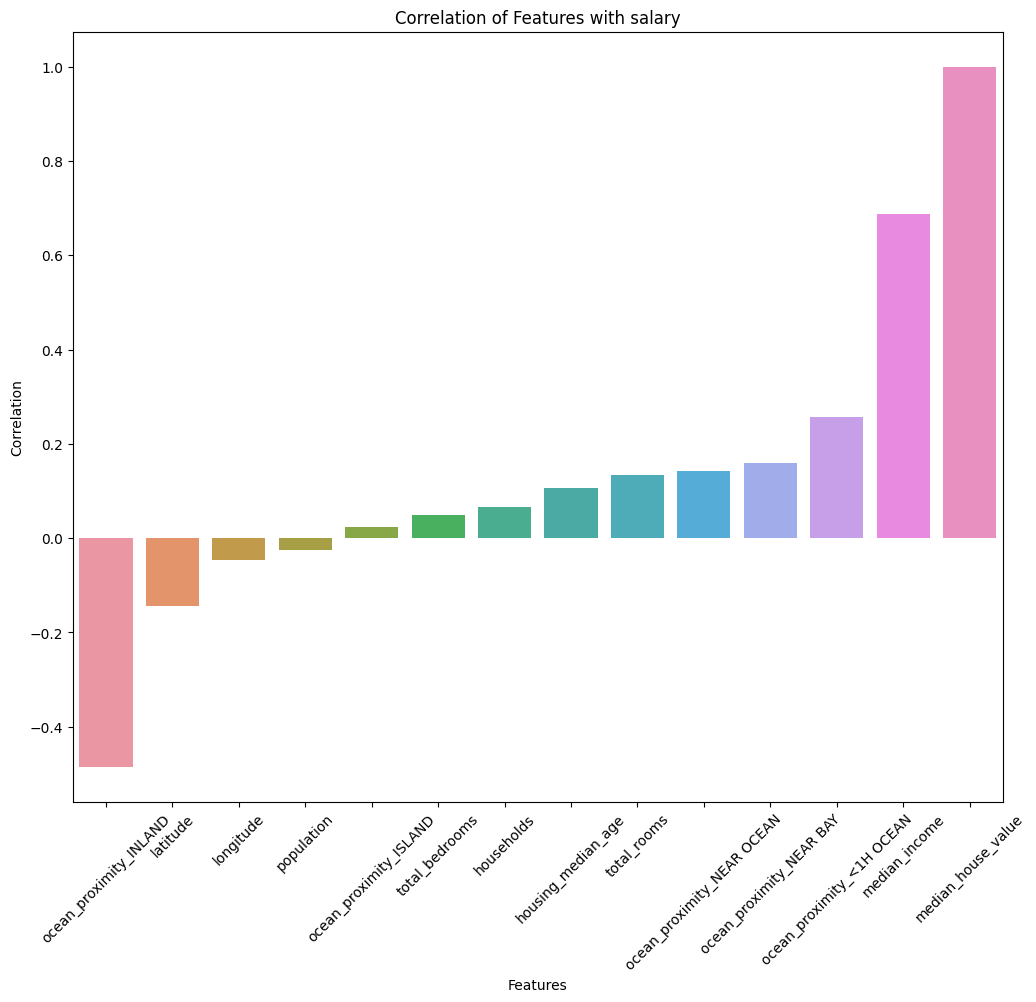

In [18]:
# Compute correlation with label column
correlation = df_encoded.corrwith(df_encoded['median_house_value'])
correlation = correlation.sort_values()
# Plot correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlation of Features with salary')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

## Missing values imputation 

I will use two methods for impute the missing values in the total_bedrooms column <br>
- using median 
- using KNN imputer 

I will evaluate each method by using a random forest regressor and calculating the R2. <br>
the method with less R2 will be choosen 

## Train Test split 

since the one hot encoding is done, I will use df_encoded 

In [19]:
df_encoded["ocean_proximity_INLAND"].dtype

dtype('int32')

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(df_encoded.drop(["median_house_value"], axis=1), df_encoded["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64', 'int32']]

## KNN Imputer

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=100)),
    ('scaler', StandardScaler())
])

In [22]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
    ])

In [23]:
# Fit and transform the data using the ColumnTransformer
X_train = preprocessor.fit_transform(X_train)

In [24]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [25]:
# Fit the regressor to your training data
model.fit(X_train, y_train)
# Make predictions on new data
y_pred = model.predict(X_valid)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [26]:
# Assuming y_true are the true target values and y_pred are the predicted target values
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: -4.210971101285105


## Mean Imputer 

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(df_encoded.drop(["median_house_value"], axis=1), df_encoded["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

In [28]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

In [29]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
    ])

In [30]:
# Fit and transform the data using the ColumnTransformer
X_train = preprocessor.fit_transform(X_train)

In [31]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [32]:
# Fit the regressor to your training data
model.fit(X_train, y_train)
# Make predictions on new data
y_pred = model.predict(X_valid)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [33]:
# Assuming y_true are the true target values and y_pred are the predicted target values
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: -4.173767152537504


## So I will use mean imputer

In [34]:
# Create a SimpleImputer object with strategy='mean'
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the column with missing values and transform the DataFrame
df_encoded['total_bedrooms'] = imputer.fit_transform(df[['total_bedrooms']])

In [35]:
df_encoded

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0,84700.0


## Outlier detection 

### I will use 3 sigma method to find the outliers <br>
#### Then I will use 2 method for handling outliers:
- smoothing the outliers using smoothing
- deleting the outliers <br>
like before, I will use random forest and R2 to evaluate which method is better

## Removing the outliers

In [36]:
cleaned_df = df_encoded.copy()  # Create a copy of the original DataFrame

for col in numerical_cols:
    if col != "salary":
        lower_limit = cleaned_df[col].mean() - 3 * cleaned_df[col].std()
        upper_limit = cleaned_df[col].mean() + 3 * cleaned_df[col].std()

        # Filter rows to include only values within the threshold
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_limit) & (cleaned_df[col] <= upper_limit)]

# Reset index to ensure a continuous index after deleting rows
cleaned_df.reset_index(drop=True, inplace=True)

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["median_house_value"], axis=1), cleaned_df["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

In [38]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [39]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
    ])

In [40]:
# Fit and transform the data using the ColumnTransformer
X_train = preprocessor.fit_transform(X_train)

In [41]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [42]:
# Fit the regressor to your training data
model.fit(X_train, y_train)
# Make predictions on new data
y_pred = model.predict(X_valid)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [43]:
# Assuming y_true are the true target values and y_pred are the predicted target values
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: -4.17235511746786


## Smoothing the outliers

In [44]:
cleaned_df = df_encoded.copy()  # Create a copy of the original DataFrame

for col in numerical_cols[:9]:
    lower_limit = df_encoded[col].mean() - 3 * df_encoded[col].std()
    upper_limit = df_encoded[col].mean() + 3 * df_encoded[col].std()

    # Replace values outside the threshold with the respective limit
    cleaned_df[col] = df_encoded[col].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))


In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["median_house_value"], axis=1), cleaned_df["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

In [46]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [47]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
    ])

In [48]:
# Fit and transform the data using the ColumnTransformer
X_train = preprocessor.fit_transform(X_train)

In [49]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [50]:
# Fit the regressor to your training data
model.fit(X_train, y_train)
# Make predictions on new data
y_pred = model.predict(X_valid)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [51]:
# Assuming y_true are the true target values and y_pred are the predicted target values
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: -4.023784610322595


### Smoothing the outliers are a better appraoch

## Feature selection 

I will use Two approaches for findig features: <br>
- PCA
- Mutual Information

I will evaluate each method via RF training and finding R2

## PCA

In [52]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["median_house_value"], axis=1), cleaned_df["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

In [53]:
# Define the pipeline with PCA and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),     # Standardize features
    ('pca', PCA(n_components=9)),     # Perform PCA for dimensionality reduction
    ('rf', RandomForestRegressor(n_estimators=100, random_state=0))  # RandomForest Classifier
])

In [54]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=9)),
                ('rf', RandomForestRegressor(random_state=0))])

In [55]:
# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_valid)

In [56]:
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: -4.023784610322595


## Mutual information

In [57]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df.drop(["median_house_value"], axis=1), cleaned_df["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

transforming X_train

In [58]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Perform mutual information feature selection
selector = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features
selector.fit(X_train, y_train)

# Get the selected features
selected_features_indices = selector.get_support(indices=True)
X_train = X_train[:, selected_features_indices]


transforming X_valid

In [59]:
# Standardize the features
scaler = StandardScaler()
X_valid = scaler.fit_transform(X_valid)

In [60]:
X_valid = X_valid[:, selected_features_indices]

In [61]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [62]:
# Fit the regressor to your training data
model.fit(X_train, y_train)
# Make predictions on new data
y_pred = model.predict(X_valid)

In [63]:
r2 = r2_score(y_valid, y_pred)
print("R2 Score:", r2)

R2 Score: 0.7725705810157975


## Mutual information outperforms PCA we will use MI 

In [64]:
selected_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

## saving every process we made in DF variable 

In [65]:
df = pd.concat([cleaned_df.iloc[: , selected_features_indices],cleaned_df["median_house_value"]] ,axis=1)

In [66]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,84700.0


## Feature selection is done and now we are ready to fine tune a polynomial Regression model 

In [67]:

mse_values = []

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["median_house_value"], axis=1), df["median_house_value"], train_size=0.6, test_size=0.4,random_state=0)

In [69]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [70]:
# Standardize the features
scaler = StandardScaler()
X_valid = scaler.fit_transform(X_valid)

In [71]:
y_train.reset_index(drop=True, inplace=True)

In [72]:
degree =1 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")


degree 1 is complete


In [73]:
degree =2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")

degree 2 is complete


In [74]:
degree =3
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")

degree 3 is complete


In [75]:
degree =4
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")

degree 4 is complete


In [76]:
degree =5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")

degree 5 is complete


In [77]:
degree =6
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_fold = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_fold)
    X_val_poly = poly_features.transform(X_val_fold)
    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_fold)
    # Predict on validation data
    y_val_pred = model.predict(X_val_poly)
    # Calculate MSE and store it
    mse_fold.append(mean_squared_error(y_val_fold, y_val_pred))
# Calculate average MSE for this degree across all folds
mse_values.append(np.mean(mse_fold))
print(f"degree {degree} is complete")

degree 6 is complete


In [88]:
mse_values


[4420426442.931594,
 3665740588.242549,
 3813799742.49631,
 12858039026.58191,
 1470524844174.3076,
 1.2334014623565216e+16]

### The 6th degree is the most I can get from my system :(

In [79]:
degrees = np.arange(1, 7)

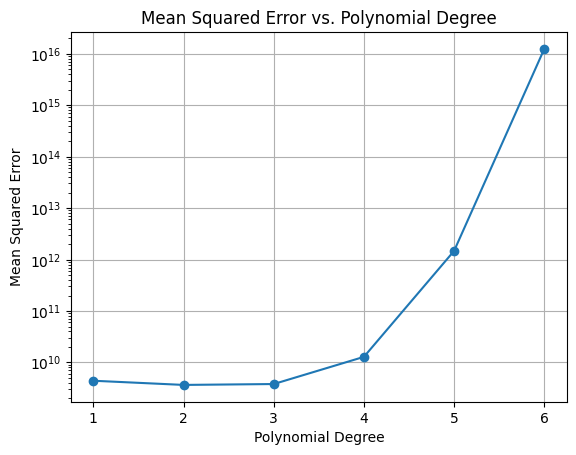

In [83]:
plt.plot(degrees, mse_values, marker='o')
plt.title('Mean Squared Error vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.yscale('log')  # Set x-axis scale to logarithmic
plt.xticks(degrees)
plt.grid(True)
plt.show()


## Second degree has the least MSE 